<a href="https://colab.research.google.com/github/Edwin-Cheng/resistor_network_DNN/blob/main/Copy_of_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import pickle
from matplotlib.colors import Normalize, CenteredNorm
import networkx as nx
import time

In [2]:
nx.grid_graph()
nx.hexagonal_lattice_graph()
nx.triangular_lattice_graph()
nx.empty_graph()

TypeError: grid_graph() missing 1 required positional argument: 'dim'

# Generate Graph


In [5]:
def generate_graph(network_type,L = 10,m = 4,N = 100, p=0.01, k=5, ring_links=[1], periodic=False):
    if network_type == 'square':
        G = nx.grid_graph((L,L), periodic= periodic)
    elif network_type == 'hex':
        G = nx.hexagonal_lattice_graph(2*m-1,2*m-1, with_positions =True)
        cx, cy = m-0.5, 2*m -(m%2) #center
        nodes_to_remove = [n for n in G.nodes if (abs(cx-n[0]) + abs(cy-n[1])) > 2*m]
        G.remove_nodes_from(nodes_to_remove)
    elif network_type == 'hex2':
        G = nx.hexagonal_lattice_graph(L//2,L, with_positions =True, periodic= periodic)
    elif network_type == 'tri':
        G = nx.triangular_lattice_graph(L-1,2*(L-1), with_positions =True)
    elif network_type == 'per_att':
        G = nx.empty_graph(create_using=nx.MultiGraph)
        for i in range(3):
            G.add_edges_from([(0,2),(1,2)])
        for t in range(3,N):
            G.add_node(t)
            degrees = np.array([d for n,d in G.degree()])
            degrees[-1] = 1
            for i in range(m):
                P = degrees/(2*m*t+1+i)
                #print(degrees)
                n = np.random.choice(np.arange(t+1),p=P)
                G.add_edge(t,n)
                degrees[n] += 1
    elif network_type == 'ER':
        G = nx.fast_gnp_random_graph(N, p)
        G.remove_nodes_from(list(nx.isolates(G)))
        G.remove_edges_from(nx.selfloop_edges(G))
    elif network_type == 'uni_con':
        ks = k*np.ones(N, dtype=np.int8)
        G = nx.configuration_model(ks)
        G.remove_edges_from(nx.selfloop_edges(G))
    elif network_type == 'ring':
        G = nx.circulant_graph(N, ring_links)
    elif network_type == 'cube':
        G = nx.grid_graph((L,L,L), periodic= periodic)
    return G

def supply_V(V, i, A, V_in):
    A[i, :] = np.zeros(len(V_in))
    A[i, i] = 1
    V_in[i] = V

def get_V(G, high_V, low_V):
    C = nx.to_numpy_array(G)
    N = nx.number_of_nodes(G)
    V_in = np.zeros(N)
    A = -C
    np.fill_diagonal(A, np.maximum(np.sum(C, axis=1), 1))
    supply_V(1, high_V, A, V_in)
    supply_V(0, low_V, A, V_in)
    V = np.linalg.solve(A, V_in)
    return V

def get_dV(G, V, edge, high_V, low_V):
    G_copy = G.copy()
    G_copy.remove_edge(*edge)
    V_new = get_V(G_copy, high_V, low_V)
    return V_new - V

def para_up(e1, d):
    (x1a,y1a),(x1b,y1b) = e1
    x2a = x1a
    x2b = x1b
    y2a = y2b = y1a+d
    e2 = ((x2a,y2a),(x2b,y2b))
    return e2

def sym_xy(e1):
    (x1a,y1a),(x1b,y1b) = e1
    e2 = ((y1a,x1a),(y1b,x1b))
    return e2

def reflect(e1,L):
    l=L-1
    (x1a,y1a),(x1b,y1b) = e1
    e2 = ((l-y1a,l-x1a),(l-y1b,l-x1b))
    return e2

def pair(n, L):
    x, y = n
    l=L-1
    n2 = (l-x,l-y)
    return n2

def plot_graph(G, V, network_type):
    nodes_list = list(G.nodes())
    G = nx.DiGraph(G)
    G.remove_edges_from([(u, v) for u, v in G.edges if V[nodes_list.index(u)] < V[nodes_list.index(v)]])
    if network_type == 'ring':
        pos = nx.circular_layout(G, scale=2)
    else:
        pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
    fig, ax = plt.subplots(figsize=(7, 7))
    nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=V, cmap=plt.cm.Blues, node_size=50, ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=Normalize(vmin=np.min(V), vmax=np.max(V))), ax=ax, label='voltage (V)')
    ax.axis('scaled')
    plt.show()

def plot_node_dV(G, dV, network_type):
    weights = [w for u, v, w in G.edges(data='weight')]
    if network_type == 'ring':
        pos = nx.circular_layout(G)
    else:
        pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
    norm = CenteredNorm(halfrange=max(abs(np.min(dV)), abs(np.max(dV))))
    fig, ax = plt.subplots(figsize=(7, 7))
    nx.draw(G, with_labels=False, pos=pos,
            edgecolors='k',
            node_color=norm(dV), cmap=plt.cm.bwr, vmin=0, vmax=1, ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=norm), ax=ax, label='voltage change (V)')
    ax.axis('scaled')
    plt.show()

def compute_error_slopes(G, V, high_V, low_V, L=None):
    edges = G.edges()
    errs = np.zeros(len(edges))
    i = 0
    for e1 in edges:
        if L and (abs(e1[0][0] - e1[0][1]) == L - 1 or abs(e1[1][0] - e1[1][1]) == L - 1):
            i += 1
            continue

        G1 = G.copy()
        G1.remove_edge(*e1)
        e2 = reflect(e1, L) if L else sym_xy(e1)

        dV1 = get_dV(G, V, e1, high_V, low_V)
        dV2 = get_dV(G, V, e2, high_V, low_V)
        dVb = get_dV(G1, V, e2, high_V, low_V)

        dV_err = (dV1 + dV2) - dVb
        slope = np.polyfit(dVb, dV_err, 1)[0]

        errs[i] = slope
        i += 1
    return errs

def plot_error_slopes(G, errs):
    plt.figure()
    ncolors = ['k'] * nx.number_of_nodes(G)
    c_map = plt.cm.rainbow
    pos = {(x, y): (x, y) for x, y in G.nodes()}
    Vmin = np.min(errs)
    Vmax = np.max(errs)
    sm = plt.cm.ScalarMappable(cmap=c_map, norm=plt.Normalize(vmin=Vmin, vmax=Vmax))
    nx.draw_networkx_nodes(G, pos, node_color=ncolors, node_size=100)
    nx.draw_networkx_edges(G, pos, edge_color=errs, width=4, edge_cmap=c_map)
    sm._A = []
    plt.colorbar(sm, label='voltage change (V)')
    plt.axis('scaled')
    plt.show()

def plot_relative_error(L, high_V, low_V, mode='distance', L_0=None, L_max=None):
    if mode == 'distance':
        G = nx.grid_graph((L,L))
        V = get_V(G, high_V, low_V)
        err_d = np.zeros(L//4-1)
        for i, d in enumerate(range(L//4-1)):
            e1 = ((L/2-1+d,d),(L/2+d,d))
            e2 = reflect(e1,L)
            G1 = G.copy()
            G1.remove_edge(*e1)
            dV1 = get_dV(G, V, e1, high_V, low_V)
            dV2 = get_dV(G, V, e2, high_V, low_V)
            dVb = get_dV(G1, V, e2, high_V, low_V)
            dV_err = (dV1+dV2)-dVb
            slope = np.polyfit(dVb,dV_err,1)[0]
            err_d[i] = slope

        plt.figure()
        plt.title('relative error against distance')
        plt.xlabel('d')
        plt.ylabel('relative error')
        plt.plot(L-np.arange(4,L,4), err_d)
        plt.show()
    elif mode == 'network_size':
        if L_0 is None or L_max is None:
            raise ValueError("Both L_0 and L_max must be defined for mode 'network_size'")
        err_L = np.zeros(int((L_max-L_0)/2))
        for i, L in enumerate(range(L_0,L_max,2)):
            G = nx.grid_graph((L,L))
            V = get_V(G, high_V, low_V)
            e1 = ((L/2-1,0),(L/2,0))
            e2 = sym_xy(e1)
            G1 = G.copy()
            G1.remove_edge(*e1)
            dV1 = get_dV(G, V, e1, high_V, low_V)
            dV2 = get_dV(G, V, e2, high_V, low_V)
            dVb = get_dV(G1, V, e2, high_V, low_V)
            dV_err = (dV1+dV2)-dVb
            slope = np.polyfit(dVb,dV_err,1)[0]
            err_L[i] = slope

        plt.figure()
        plt.title('relative error against size of network')
        plt.xlabel('L')
        plt.ylabel('relative error')
        plt.plot(np.arange(L_0,L_max,2), err_L)
        plt.show()
    else:
        raise ValueError("Invalid mode. Expected 'distance' or 'network_size'")

def names_to_index(G, names):
    nodes_list = list(G.nodes())
    indexs = np.zeros(len(names))
    i = 0
    for n in names:
        indexs[i] = nodes_list.index(n)
        i += 1
    return indexs

def get_distance_distribution(G):
    nodes = G.nodes()
    length = dict(nx.all_pairs_shortest_path_length(G))
    ls = []
    for u in nodes:
        for v in nodes:
            if u!=v:
                ls.append(length[u][v])
    r, n_r = np.unique(np.array(ls), return_counts=True)
    return r, n_r

def get_dim(G,cutoff = 5):
    r, n_r = get_distance_distribution(G)
    #discard = int(len(r)/3)*2
    x, y = np.log(r[0:cutoff]), np.log(n_r[0:cutoff])
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m+1


# 'ring'
find dimension of rings with added edges

DEFINING DIMENSION OF A COMPLEX NETWORK, O. SHANKER , Modern Physics Letters B 2007 21:06, 321-326
https://doi.org/10.1142/S0217984907012773

In [ ]:
network_type = 'ring'
samples = 100
dim = np.zeros(samples)
N=120
m=10
ps = np.linspace(0,1,samples)
for i,p in enumerate(ps):
    G = generate_graph(network_type, N=N)
    for n in range(nx.number_of_nodes(G)):
        #if p>np.random.rand(): G.add_edge(n,int(np.random.rand()*nx.number_of_nodes(G)))
        if p>np.random.rand(): G.add_edge(n,int((n+m)%N))
    dim[i] = get_dim(G)
plt.scatter(ps, dim)
plt.xlabel('p')
plt.ylabel('d')

# 'square'
find dimension of square network after link swap

In [ ]:
network_type = 'square'
G = generate_graph(network_type, L=10)
for i in range(100):
    nx.double_edge_swap(G)
r, n_r = get_distance_distribution(G)
#plt.plot(r,n_r)
plt.plot(np.log(r), np.log(n_r))
get_dim(G)

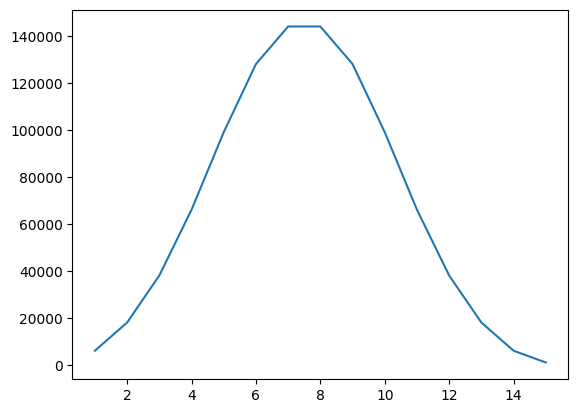

In [ ]:
plt.plot(r,n_r)

# 'hex2'

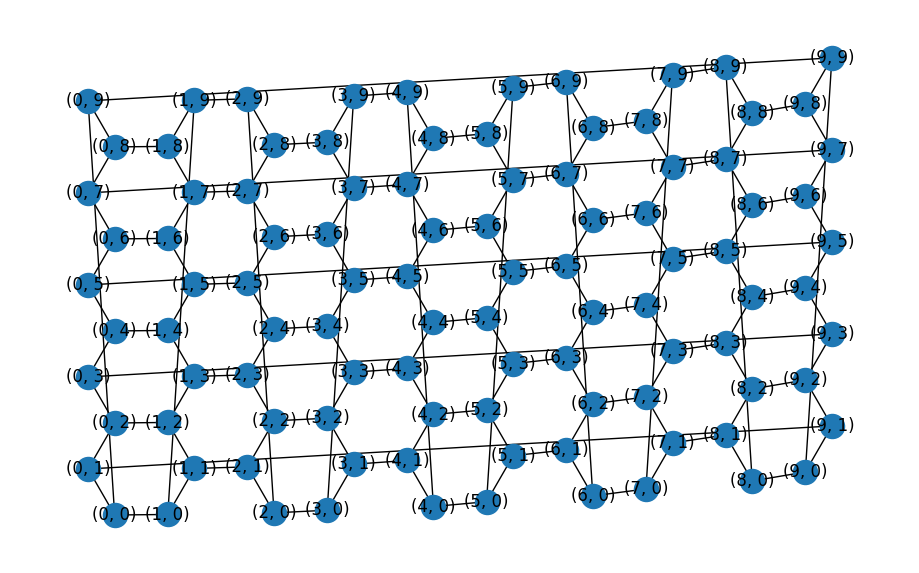

100


In [ ]:
network_type = 'hex2'
G = generate_graph(network_type, L=10, periodic=True)
plt.figure(figsize=(9,9))
pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
nx.draw(G, pos=pos, with_labels=True)
plt.axis('scaled')
plt.show()
print(G.number_of_nodes())

# Generate Training Data

In [ ]:
def generate_training_data(G, network_type, high_V, low_V, filename, num_samples=-1, num_inputs=4, ran=0, noise=0.1):
    N = nx.number_of_nodes(G)
    nodes_list = list(G.nodes())
    midpoints = []
    for n in list(G[nodes_list[high_V]]):
        midpoints.append(n)
    for n in list(G[nodes_list[low_V]]):
        midpoints.append(n)
    L = int(np.sqrt(N)) # Assuming square grid
    if network_type == 'square' or network_type == 'tri' or network_type == 'hex2':
        #midpoints = [(0, L//2), (L//2, 0), (L-1, L//2), (L//2, L-1), (0, L-1), (L-1, 0), (L//2, L//2)]
        #midpoints = [(0, L//2), (L//2, 0), (L-1, L//2), (L//2, L-1), (0, L-1), (L-1, 0)]
        #midpoints = [(0, L//2), (L//2, 0), (L-1, L//2), (L//2, L-1), (L//2, L//2)]
        midpoints = [(0, L//2), (L//2, 0), (L-1, L//2), (L//2, L-1)]
        #midpoints = [(0, L//2), (L//2, 0)]
    if network_type == 'hex':
        #midpoints = [(0, 12), (7, 12), (0, 4), (7, 4), (3, 15), (4, 1), (2, 8), (5, 8), (2, 4), (5, 12)]
        #midpoints = [(0, 12), (7, 12), (0, 4), (7, 4), (3, 15), (4, 1), (2, 8), (5, 8)]
        #midpoints = [(0, 12), (7, 12), (0, 4), (7, 4), (3, 15), (4, 1)]
        midpoints = [(0, 12), (7, 12), (0, 4), (7, 4)]
        #midpoints = [(3, 15), (4, 1)]
    if network_type == 'ring':
        m = int(num_inputs+2)
        midpoints = np.append(np.arange(1,m/2),np.arange(m/2+1,m))
        midpoints = N/m*midpoints
    #n1 = (0,9)
    #midpoints = [n1, pair(n1, L)]
    if network_type == 'per_att':
        degrees = G.degree
        hubs = sorted(degrees, key=lambda x: x[1], reverse=True)
        hubs = [n for n, k in hubs]
        hubs.remove(0)
        hubs.remove(1)
    if network_type == 'ER' or network_type == 'uni_con':
        midpoints = np.random.choice(G.nodes(), num_inputs)

    print(midpoints)
    for i in range(ran):
        nx.double_edge_swap(G)
    edges = list(G.edges)
    if num_samples == -1:
        num_samples = len(edges)
    V_original = get_V(G, high_V, low_V)
    with open(filename, 'w') as f:
        for i in range(num_samples):
            if i == num_samples//4:
                print('0.25 complete')
            # Randomly disconnect an edge
            #edge_to_remove = random.choice(edges)
            edge_to_remove = edges[i]
            # Calculate voltage changes
            dV = get_dV(G, V_original, edge_to_remove, high_V, low_V)
            # Prepare inputs: dV for each midpoint
            inputs = []
            if network_type == 'square':
                for x, y in midpoints:
                    node_index = x * L + y # Assuming nodes are numbered row-wise from 0 to N-1
                    inputs.append(dV[node_index])
            elif network_type == 'per_att':
                for i in range(num_inputs):
                    node_index = hubs[i]
                    inputs.append(dV[node_index])
            else:
                for n in midpoints:
                    node_index = nodes_list.index(n)
                    inputs.append(dV[node_index])
            # Prepare output: index of disconnected edge
            output = edges.index(edge_to_remove)
            # Write to file
            for _ in range(10):
                ran_in = np.array(inputs)*(1+(np.random.rand(num_inputs)-0.5)*2*noise)
                f.write(','.join(map(str, ran_in)) + ',' + str(output) + '\n')


def main():
    network_type = 'ring'
    #G = generate_graph(network_type, L, N=100, m=2)
    G = generate_graph(network_type, N=60)
    nodes_list = list(G.nodes())
    high_V = nodes_list.index((0,8)) if network_type == 'hex' else 0
    low_V = nodes_list.index((7,8)) if network_type == 'hex' else -1
    #ring
    high_V = 0
    low_V = 30
    #low_V = 2  #per_att
    print(G)
    generate_training_data(G, network_type, high_V, low_V, 'training_data.txt',
                           num_samples=-1, num_inputs=4, ran=0)

if __name__ == "__main__":
    main()


# # Assuming 'output' is the output of your model (the index of the disconnected edge)
# # and 'edges' is the list of edges in the network
#
# disconnected_edge = edges[output]
#
# # The nodes of the edge are tuples of (x, y) coordinates
# node1, node2 = disconnected_edge
#
# print(f"The disconnected edge is between nodes {node1} and {node2}")


# Training Pipeline

In [ ]:
# Seed setup and early stopping classes remain the same...
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt') # 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

# Data loading
filename = 'training_data.txt'
data = pd.read_csv(filename, header=None)
X = data.values[:,:-1]
y = data.values[:,-1]

# Convert targets to one-hot encoding
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# DNN model
class DNN(torch.nn.Module):
    def __init__(self, hidden, num_classes):
        super(DNN, self).__init__()
        self.out = torch.nn.Sequential(
            torch.nn.Linear(hidden[0], hidden[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden[1], hidden[2]),
            torch.nn.ReLU(),
            # torch.nn.Linear(hidden[2], hidden[3]),
            # torch.nn.ReLU(),
            torch.nn.Linear(hidden[2], num_classes)
        )
        for layer in self.out:
            if type(layer) == torch.nn.Linear:
                torch.nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.out(x)
        return out

class Pipeline:
    def __init__(self, X_train, X_test, y_train, y_test, learning_rate, hidden_size, num_classes, epochs, patience):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.epochs = epochs
        self.patience = patience

    def _feature_process(self):
        X_scaler = StandardScaler()
        self.X_scaler = X_scaler
        X_train = self.X_train
        X_test = self.X_test
        y_train = self.y_train
        y_test = self.y_test
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)
        X_train = torch.from_numpy(X_train[:, np.newaxis, :]).float()
        X_test = torch.from_numpy(X_test[:, np.newaxis, :]).float()
        y_train = torch.from_numpy(y_train).float()
        y_test = torch.from_numpy(y_test).float()
        if torch.cuda.is_available():
            X_train = X_train.cuda()
            X_test = X_test.cuda()
            y_train = y_train.cuda()
            y_test = y_test.cuda()
        self.X_test = X_test
        self.y_test = y_test
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
        return train_dataloader, test_dataloader

    def _build_model(self):
        #setup_seed(0)
        model = DNN(self.hidden_size, self.num_classes)
        if torch.cuda.is_available():
            model = model.cuda()
        return model

    def _run(self, train_dataloader, test_dataloader, model, epochs, patience=1000):
        early_stopping = EarlyStopping(patience, verbose=True)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=0.00001)
        for epoch in range(epochs):  #Total training steps, modify it when you need
            model.train()
            train_loss = list()
            for data in train_dataloader:
                optimizer.zero_grad()
                X_, y_ = data
                output = model(X_)
                loss = criterion(output, torch.max(y_, 1)[1])
                train_loss.append(loss.item())
                loss.backward()
                optimizer.step()
            #print('train_loss:', np.mean(train_loss))

            with torch.no_grad():
                test_loss = list()
                model.eval()
                for data in test_dataloader:
                    X_, y_ = data
                    output = model(X_)
                    loss = criterion(output, torch.max(y_, 1)[1])
                    test_loss.append(loss.item())
                #print("test_loss:", np.mean(test_loss))
                early_stopping(np.mean(test_loss), model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        model.load_state_dict(torch.load('checkpoint.pt'))
        return model

    def get_metrics(self, model):
        y_pred = model(self.X_test).cpu().detach().numpy()
        y_test = self.y_test.cpu().detach().numpy()
        accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        result = {
            'y_test': np.argmax(y_test, axis=1),
            'y_pred': np.argmax(y_pred, axis=1)
        }
        return accuracy, result

    def run(self):
        train_dataloader, test_dataloader = self._feature_process()
        model = self._build_model()
        model = self._run(train_dataloader, test_dataloader, model, epochs=self.epochs)
        accuracy, result = self.get_metrics(model)
        return accuracy, result, model, self.X_scaler



# Training with data from main() in 'generate training data'

In [ ]:
### Change here ####
num_classes = y.shape[1]  # Number of categories (edges)
pipeline = Pipeline(X_train, X_test, y_train, y_test, 0.0015, [4,128,128], num_classes,  epochs=20000)     #structure of DNN
accuracy, result, model, scaler = pipeline.run()
print(f"The model accuracy is {accuracy}")
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model_info.txt', 'w') as f:
    f.write(f'num_classes: {num_classes}\n')
    f.write(f'accuracy: {accuracy}\n')

Validation loss decreased (inf --> 4.030125).  Saving model ...
Validation loss decreased (4.030125 --> 3.472145).  Saving model ...
Validation loss decreased (3.472145 --> 3.155471).  Saving model ...
Validation loss decreased (3.155471 --> 2.949131).  Saving model ...
Validation loss decreased (2.949131 --> 2.780943).  Saving model ...
Validation loss decreased (2.780943 --> 2.654418).  Saving model ...
Validation loss decreased (2.654418 --> 2.553426).  Saving model ...
Validation loss decreased (2.553426 --> 2.486947).  Saving model ...
Validation loss decreased (2.486947 --> 2.449955).  Saving model ...
Validation loss decreased (2.449955 --> 2.426483).  Saving model ...
Validation loss decreased (2.426483 --> 2.409440).  Saving model ...
Validation loss decreased (2.409440 --> 2.397580).  Saving model ...
Validation loss decreased (2.397580 --> 2.393048).  Saving model ...
Validation loss decreased (2.393048 --> 2.392899).  Saving model ...
Validation loss decreased (2.392899 -->

# Plot the network with nodes selected for voltage measurement


In [3]:
def plot_inputs(G, network_type, high_V, low_V, inputs):

    plt.figure(figsize=(9,9))
    if network_type == 'ring':
        pos = nx.circular_layout(G, scale=2)
    else:
        pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
    nodes_list = list(G.nodes())

    colors = np.empty(nx.number_of_nodes(G), dtype=str)
    i = 0
    for n in nodes_list:
        if n in inputs:
            colors[i] = 'b'
        else:
            colors[i] = 'w'
        i+=1
    colors[high_V] = 'r'
    colors[low_V] = 'k'
    nx.draw(G, pos=pos, node_color=colors, edgecolors='k')
    plt.axis('scaled')
    plt.show()

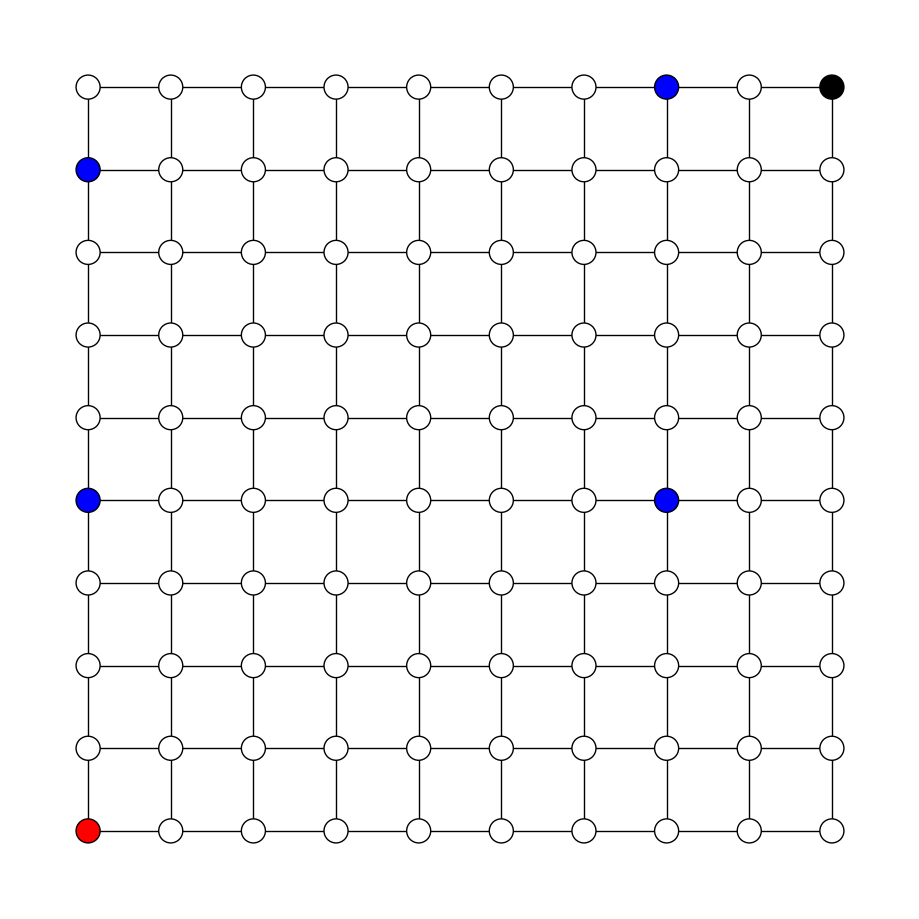

In [7]:
G = generate_graph('square')
plot_inputs(G, 'square', 0, -1, [(0, 8), (7, 9), (0, 4), (7, 4)])

# Training with 'ER' data

In [ ]:
samples = 5
accs = np.zeros(samples)
start = time.time()
network_type = 'ER'

dim = np.zeros(samples)
N=240
m=12
ps = np.linspace(0.3,0.4,samples)
for i,p in enumerate(ps):
    G = generate_graph(network_type, N=N, ring_links=[1])
    #for n in range(nx.number_of_nodes(G)):
        #if p>np.random.rand(): G.add_edge(n,(n+m)%N)
    dim[i] = get_dim(G)
    nodes_list = list(G.nodes())
    high_V = nodes_list.index((0,8)) if network_type == 'hex' else 0
    low_V = nodes_list.index((7,8)) if network_type == 'hex' else -1
    #ring
    high_V = 0
    low_V = int(N/2)
    generate_training_data(G, network_type, high_V, low_V, f'training_data_{network_type[1:-1]}.txt',
                           num_samples=-1, num_inputs=4, ran=0)



    # Data loading
    filename = 'training_data.txt'
    data = pd.read_csv(filename, header=None)
    X = data.values[:,:-1]
    y = data.values[:,-1]

    # Convert targets to one-hot encoding
    encoder = OneHotEncoder(sparse=False)
    y = encoder.fit_transform(y.reshape(-1, 1))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    num_classes = y.shape[1]  # Number of categories (edges)
    pipeline = Pipeline(X_train, X_test, y_train, y_test, 0.0015, [4,64,64], num_classes)     #structure of DNN
    accuracy, result, model, scaler = pipeline.run()

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    accs[i] = accuracy

with open('model_info.txt', 'w') as f:
    f.write(f'{ps}\n')
    f.write(f'{dim}\n')
    f.write(f'{accs}\n')

time_taken = time.time()-start
print(f'time taken for {samples} runs: {time_taken}')
print(f'average run time: {time_taken/runs}')

[ 40.  80. 160. 200.]
0.25 complete


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.640233).  Saving model ...
Validation loss decreased (5.640233 --> 5.335421).  Saving model ...
Validation loss decreased (5.335421 --> 5.035264).  Saving model ...
Validation loss decreased (5.035264 --> 4.743248).  Saving model ...
Validation loss decreased (4.743248 --> 4.489918).  Saving model ...
Validation loss decreased (4.489918 --> 4.265842).  Saving model ...
Validation loss decreased (4.265842 --> 4.048395).  Saving model ...
Validation loss decreased (4.048395 --> 3.852946).  Saving model ...
Validation loss decreased (3.852946 --> 3.667297).  Saving model ...
Validation loss decreased (3.667297 --> 3.501001).  Saving model ...
Validation loss decreased (3.501001 --> 3.344643).  Saving model ...
Validation loss decreased (3.344643 --> 3.207634).  Saving model ...
Validation loss decreased (3.207634 --> 3.078758).  Saving model ...
Validation loss decreased (3.078758 --> 2.968216).  Saving model ...
Validation loss decreased (2.968216 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.670349).  Saving model ...
Validation loss decreased (5.670349 --> 5.375330).  Saving model ...
Validation loss decreased (5.375330 --> 5.155924).  Saving model ...
Validation loss decreased (5.155924 --> 4.926054).  Saving model ...
Validation loss decreased (4.926054 --> 4.696205).  Saving model ...
Validation loss decreased (4.696205 --> 4.479672).  Saving model ...
Validation loss decreased (4.479672 --> 4.264981).  Saving model ...
Validation loss decreased (4.264981 --> 4.071057).  Saving model ...
Validation loss decreased (4.071057 --> 3.895448).  Saving model ...
Validation loss decreased (3.895448 --> 3.739608).  Saving model ...
Validation loss decreased (3.739608 --> 3.599923).  Saving model ...
Validation loss decreased (3.599923 --> 3.475213).  Saving model ...
Validation loss decreased (3.475213 --> 3.364414).  Saving model ...
Validation loss decreased (3.364414 --> 3.262894).  Saving model ...
Validation loss decreased (3.262894 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.771482).  Saving model ...
Validation loss decreased (5.771482 --> 5.366238).  Saving model ...
Validation loss decreased (5.366238 --> 5.044604).  Saving model ...
Validation loss decreased (5.044604 --> 4.739493).  Saving model ...
Validation loss decreased (4.739493 --> 4.475742).  Saving model ...
Validation loss decreased (4.475742 --> 4.220393).  Saving model ...
Validation loss decreased (4.220393 --> 3.985299).  Saving model ...
Validation loss decreased (3.985299 --> 3.773730).  Saving model ...
Validation loss decreased (3.773730 --> 3.579472).  Saving model ...
Validation loss decreased (3.579472 --> 3.402898).  Saving model ...
Validation loss decreased (3.402898 --> 3.249628).  Saving model ...
Validation loss decreased (3.249628 --> 3.115590).  Saving model ...
Validation loss decreased (3.115590 --> 2.997384).  Saving model ...
Validation loss decreased (2.997384 --> 2.892603).  Saving model ...
Validation loss decreased (2.892603 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.790661).  Saving model ...
Validation loss decreased (5.790661 --> 5.471579).  Saving model ...
Validation loss decreased (5.471579 --> 5.237930).  Saving model ...
Validation loss decreased (5.237930 --> 5.015172).  Saving model ...
Validation loss decreased (5.015172 --> 4.774824).  Saving model ...
Validation loss decreased (4.774824 --> 4.534103).  Saving model ...
Validation loss decreased (4.534103 --> 4.294913).  Saving model ...
Validation loss decreased (4.294913 --> 4.067387).  Saving model ...
Validation loss decreased (4.067387 --> 3.859677).  Saving model ...
Validation loss decreased (3.859677 --> 3.674155).  Saving model ...
Validation loss decreased (3.674155 --> 3.513437).  Saving model ...
Validation loss decreased (3.513437 --> 3.373908).  Saving model ...
Validation loss decreased (3.373908 --> 3.250060).  Saving model ...
Validation loss decreased (3.250060 --> 3.139225).  Saving model ...
Validation loss decreased (3.139225 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.720893).  Saving model ...
Validation loss decreased (5.720893 --> 5.400740).  Saving model ...
Validation loss decreased (5.400740 --> 5.123174).  Saving model ...
Validation loss decreased (5.123174 --> 4.845500).  Saving model ...
Validation loss decreased (4.845500 --> 4.573685).  Saving model ...
Validation loss decreased (4.573685 --> 4.310581).  Saving model ...
Validation loss decreased (4.310581 --> 4.055566).  Saving model ...
Validation loss decreased (4.055566 --> 3.824461).  Saving model ...
Validation loss decreased (3.824461 --> 3.607037).  Saving model ...
Validation loss decreased (3.607037 --> 3.419469).  Saving model ...
Validation loss decreased (3.419469 --> 3.253202).  Saving model ...
Validation loss decreased (3.253202 --> 3.111858).  Saving model ...
Validation loss decreased (3.111858 --> 2.989915).  Saving model ...
Validation loss decreased (2.989915 --> 2.872934).  Saving model ...
Validation loss decreased (2.872934 -->

Text(0, 0.5, 'accuracy')

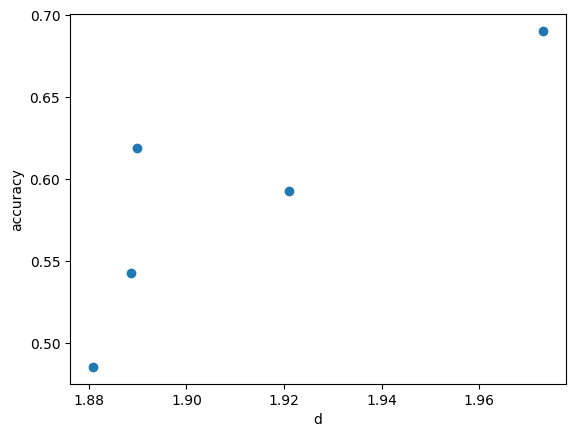

In [ ]:
plt.scatter(dim, accs)
plt.xlabel('d')
plt.ylabel('accuracy')

In [ ]:
runs = 3
accs = np.zeros(runs)
start = time.time()

N=150

p=5/N
dim= np.zeros(runs)
for i in range(runs):
    network_type = 'ER'
    G = generate_graph(network_type, N=N, p=p, periodic=False)
    print(G.number_of_nodes())
    print(G.number_of_edges())
    #for n in range(nx.number_of_nodes(G)):
        #if p>np.random.rand(): G.add_edge(n,(n+m)%N)
    #nx.draw_kamada_kawai(G,edgecolors='k')
    nodes_list = list(G.nodes())
    high_V = nodes_list.index((0,8)) if network_type == 'hex' else 0
    low_V = nodes_list.index((7,8)) if network_type == 'hex' else -1
    #ring
    #high_V = 0
    #low_V = int(N/2)
    generate_training_data(G, network_type, high_V, low_V, 'training_data.txt',
                           num_samples=-1, num_inputs=4, ran=0)



    # Data loading
    filename = 'training_data.txt'
    data = pd.read_csv(filename, header=None)
    X = data.values[:,:-1]
    y = data.values[:,-1]

    # Convert targets to one-hot encoding
    encoder = OneHotEncoder(sparse=False)
    y = encoder.fit_transform(y.reshape(-1, 1))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    num_classes = y.shape[1]  # Number of categories (edges)
    pipeline = Pipeline(X_train, X_test, y_train, y_test, 0.0015, [4,128,128], num_classes)     #structure of DNN
    accuracy, result, model, scaler = pipeline.run()

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    accs[i] = accuracy

with open('model_info.txt', 'w') as f:
    #f.write(f'num_classes: {num_classes}\n')
    f.write(f'mean accuracy: {np.mean(accs)}\n')
    f.write(f'std: {np.std(accs)}\n')
    f.write(f'max: {np.max(accs)}\n')
    f.write(f'min: {np.min(accs)}\n')
    f.write(f'{np.mean(accs)},{np.std(accs)}')

time_taken = time.time()-start
print(f'time taken for {runs} runs: {time_taken}')
print(f'average run time: {time_taken/runs}')
print(f'{np.mean(accs)},{np.std(accs)}')

148
352
[ 20  20 146   5]
0.25 complete


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.733221).  Saving model ...
Validation loss decreased (5.733221 --> 5.590480).  Saving model ...
Validation loss decreased (5.590480 --> 5.500522).  Saving model ...
Validation loss decreased (5.500522 --> 5.316020).  Saving model ...
Validation loss decreased (5.316020 --> 5.234617).  Saving model ...
Validation loss decreased (5.234617 --> 5.022169).  Saving model ...
Validation loss decreased (5.022169 --> 4.899791).  Saving model ...
Validation loss decreased (4.899791 --> 4.720825).  Saving model ...
Validation loss decreased (4.720825 --> 4.612061).  Saving model ...
Validation loss decreased (4.612061 --> 4.424652).  Saving model ...
Validation loss decreased (4.424652 --> 4.305804).  Saving model ...
Validation loss decreased (4.305804 --> 4.200469).  Saving model ...
Validation loss decreased (4.200469 --> 4.093586).  Saving model ...
Validation loss decreased (4.093586 --> 4.007764).  Saving model ...
Validation loss decreased (4.007764 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.624568).  Saving model ...
Validation loss decreased (5.624568 --> 5.415640).  Saving model ...
Validation loss decreased (5.415640 --> 5.221160).  Saving model ...
Validation loss decreased (5.221160 --> 5.009420).  Saving model ...
Validation loss decreased (5.009420 --> 4.752196).  Saving model ...
Validation loss decreased (4.752196 --> 4.525749).  Saving model ...
Validation loss decreased (4.525749 --> 4.317222).  Saving model ...
Validation loss decreased (4.317222 --> 4.121262).  Saving model ...
Validation loss decreased (4.121262 --> 3.951964).  Saving model ...
Validation loss decreased (3.951964 --> 3.808152).  Saving model ...
Validation loss decreased (3.808152 --> 3.668898).  Saving model ...
Validation loss decreased (3.668898 --> 3.552862).  Saving model ...
Validation loss decreased (3.552862 --> 3.451637).  Saving model ...
Validation loss decreased (3.451637 --> 3.371637).  Saving model ...
Validation loss decreased (3.371637 -->

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 5.687571).  Saving model ...
Validation loss decreased (5.687571 --> 5.466273).  Saving model ...
Validation loss decreased (5.466273 --> 5.328152).  Saving model ...
Validation loss decreased (5.328152 --> 5.214938).  Saving model ...
Validation loss decreased (5.214938 --> 5.096395).  Saving model ...
Validation loss decreased (5.096395 --> 4.956188).  Saving model ...
Validation loss decreased (4.956188 --> 4.811146).  Saving model ...
Validation loss decreased (4.811146 --> 4.670732).  Saving model ...
Validation loss decreased (4.670732 --> 4.543761).  Saving model ...
Validation loss decreased (4.543761 --> 4.421087).  Saving model ...
Validation loss decreased (4.421087 --> 4.308993).  Saving model ...
Validation loss decreased (4.308993 --> 4.202284).  Saving model ...
Validation loss decreased (4.202284 --> 4.094360).  Saving model ...
Validation loss decreased (4.094360 --> 3.997353).  Saving model ...
Validation loss decreased (3.997353 -->

In [ ]:
print(f'{np.mean(accs)},{np.std(accs)}')

0.8835671088576961,0.016791157169040366


# Voltage change of nodes in the ring agianst their angle


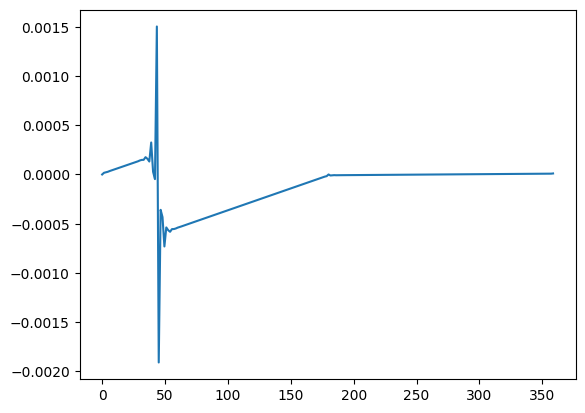

In [ ]:
network_type = 'ring'
N = 240
G = generate_graph(network_type, N=N, ring_links=[1,2,3])
#ring
high_V = 0
low_V = int(N/2)
V_0 = get_V(G, high_V, low_V)
u, v = 29,30
edge = (u, v)
dV = get_dV(G, V_0, edge, high_V, low_V)

angles = np.arange(N)/N*360
plt.plot(angles,dV)

In [ ]:
offset = 3

network_type = 'ring'
N = 120
G = generate_graph(network_type, N=N, ring_links=[1,2,3])
#ring
high_V = 0
low_V = int(N/2)
V_0 = get_V(G, high_V, low_V)

dVs = np.zeros((N,N))
for n in range(N):
    u, v = n,(n+offset)%120
    edge = (u, v)
    dVs[n] = get_dV(G, V_0, edge, high_V, low_V)



#Voltage change of nodes in the ring different angles when the edge at different angles is removed

Text(0.5, 1.0, 'N = 120, edge length = 3')

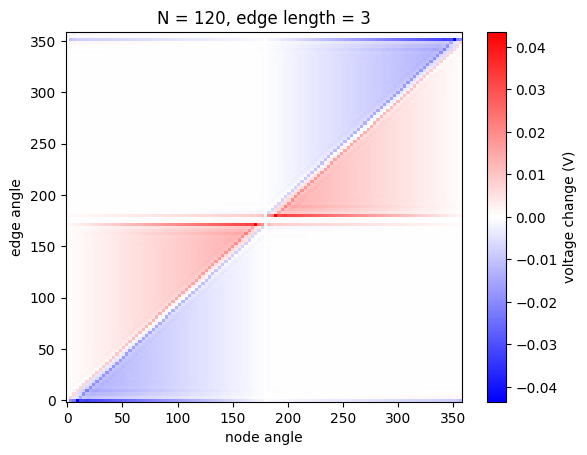

In [ ]:
angles = np.arange(N)/N*360
plt.pcolormesh(angles,angles, dVs, cmap=plt.cm.bwr)
plt.xlabel('node angle')
plt.ylabel('edge angle')
plt.colorbar(label='voltage change (V)')
plt.title(f'N = {N}, edge length = {offset}')

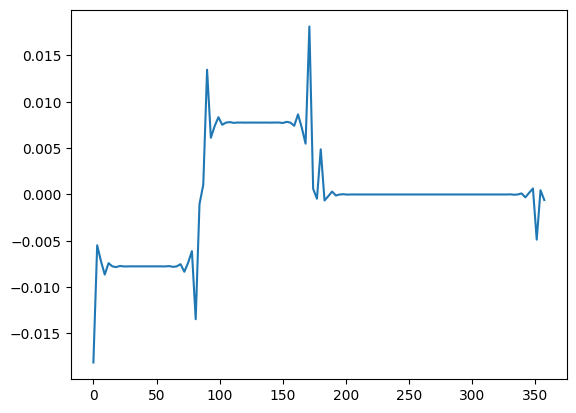

In [ ]:
plt.plot( angles, dVs[:,30])

# accuracy when p of the links in a regular network is randomly swapped

Text(0, 0.5, 'accuracy')

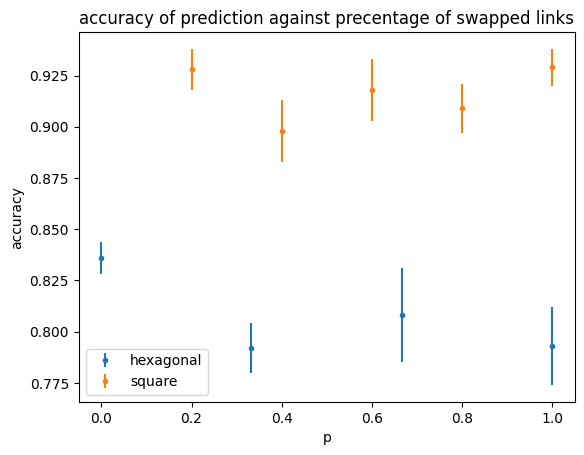

In [ ]:
#square link swapped
runs = 10
plt.figure()
swaps = np.array([0.000,0.333,0.667,1.000,])
acc = np.array([0.836,0.792,0.808,0.793,])
err = np.array([0.008,0.012,0.023,0.019,])
plt.errorbar(swaps, acc, yerr=err, fmt='.', label='hexagonal')
swaps2 = np.array([0.200,0.400,0.600,0.800,1.000,])
acc2 = np.array([0.928,0.898,0.918,0.909,0.929,])
err2 = np.array([0.010,0.015,0.015,0.012,0.009,])
plt.errorbar(swaps2, acc2, yerr=err2, fmt='.', label='square')
plt.title('accuracy of prediction against precentage of swapped links')
plt.legend()
plt.xlabel('p')
plt.ylabel('accuracy')

# accruracy for different types of resistor networks at different network size

Text(0, 0.5, 'accuracy')

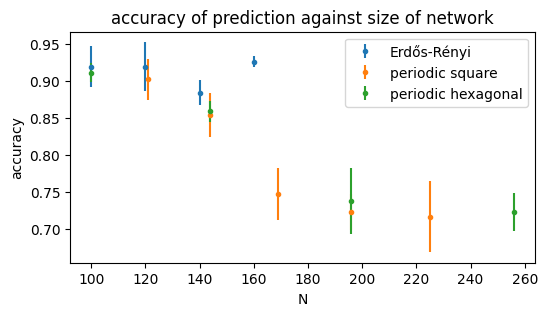

In [ ]:

plt.figure(figsize=(6,3))
x3 = np.array([100,120,140,160])
acc3 = np.array([0.919,0.919,0.884,0.926,])
err3 = np.array([0.028,0.033,0.017,0.007,])
plt.errorbar(x3, acc3, yerr=err3, fmt='.', label='Erdős-Rényi')
x4 = np.array([121,144,169,196,225])
acc4 = np.array([0.902,0.854,0.747,0.723,0.717,])
err4 = np.array([0.028,0.030,0.035,0.024,0.048,])
plt.errorbar(x4, acc4, yerr=err4, fmt='.', label='periodic square')
x5 = np.array([100,144,196,256])
acc5 = np.array([0.911,0.859,0.738,0.723,])
err5 = np.array([0.013,0.014,0.044,0.026,])
plt.errorbar(x5, acc5, yerr=err5, fmt='.', label='periodic hexagonal')
plt.title('accuracy of prediction against size of network')
plt.legend()
plt.xlabel('N')
plt.ylabel('accuracy')

# Plot ring network

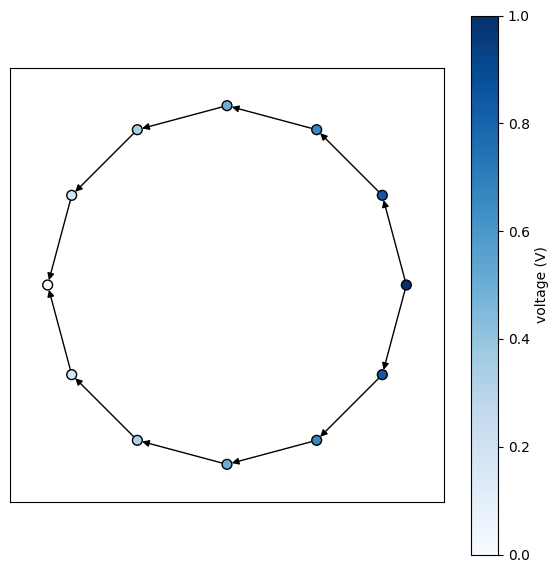

In [ ]:
network_type = 'ring'
N = 12
G = generate_graph(network_type, N=N, ring_links=[1])
nodes_list = list(G.nodes())
high_V = nodes_list.index((0,8)) if network_type == 'hex' else 0
low_V = nodes_list.index((7,8)) if network_type == 'hex' else -1
high_V = 0
low_V = int(N/2)
V= get_V(G, high_V, low_V)
plot_graph(G, get_V(G, high_V, low_V), network_type)

# accuracy when node pair at equidistant points on a line through center of network is used for voltage measurement

Text(0, 0.5, 'accuracy')

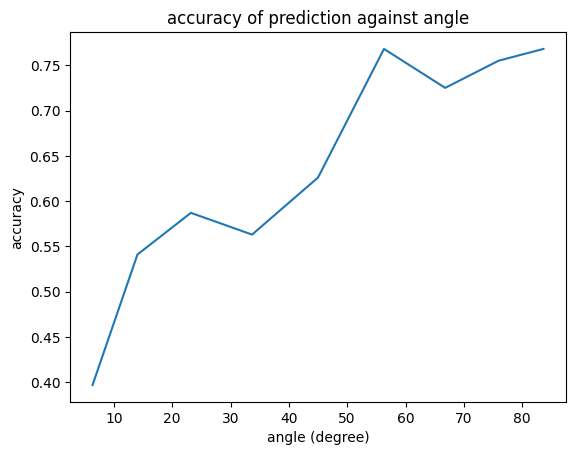

In [ ]:
#angle
plt.figure()
acc = np.array([0.397,0.541,0.587,0.563,0.626,0.768,0.725,0.755,0.768,])
angle = np.array([6.340, 14.036, 23.199, 33.690, 45.000, 56.310, 66.801, 75.964, 83.660])
plt.plot(angle, acc)
plt.title('accuracy of prediction against angle')
plt.xlabel('angle (degree)')
plt.ylabel('accuracy')

[0.12435499 0.27829966 0.46364761 0.67474094 0.89605538 1.10714872
 1.29249667 1.44644133 1.57079633 0.16514868 0.38050638 0.64350111
 0.92729522 1.19028995 1.40564765 1.57079633 0.24497866 0.5880026
 0.98279372 1.32581766 1.57079633 0.46364761 1.10714872 1.57079633
 1.57079633]


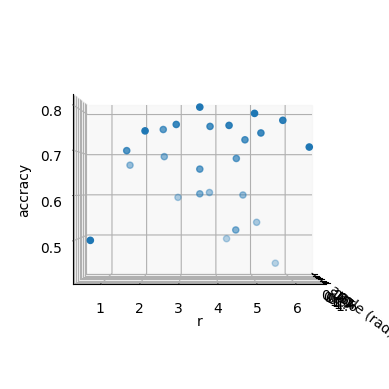

In [ ]:
#node pair at equidistant points on a link through center of network
coor = np.array([[1,0],[2,0],[3,0],[4,0],[5,0],[6,0],[7,0],[8,0],[9,0],[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[3,2],[4,2],[5,2],[6,2],[7,2],[4,3],[5,3],[6,3],[5,4],])
acc = np.array([0.431,0.533,0.600,0.517,0.686,0.728,0.742,0.769,0.708,0.492,0.606,0.603,0.661,0.758,0.758,0.783,0.594,0.692,0.753,0.761,0.797,0.672,0.703,0.744,0.500,])
L=10
V_sources = np.array([[0,0],[9,9]])

angle = np.zeros(len(acc))
r = np.zeros(len(acc))

#calculate distance and angle from coor
mid = np.sum(V_sources,axis=0)/2
v_s = V_sources[1]-V_sources[0]
R = np.sqrt(np.dot(v_s,v_s))
i=0
for co in coor:
    r[i] = np.sqrt((co[0]-mid[0])**2+(co[1]-mid[1])**2)

    v = np.array(pair(co, L))-co
    angle[i] = np.arccos(np.dot(v, v_s) / (R*np.sqrt(np.dot(v,v))))

    i+=1

print(angle)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(angle, r, acc)

ax.set_xlabel('angle (rad)')
ax.set_ylabel('r')
ax.set_zlabel('accracy')

#ax.view_init(elev=0, azim=-90)
ax.view_init(elev=0, azim=0)

from mpl_toolkits.mplot3d import Axes3D

def on_move(event):
    if event.inaxes == ax:
        ax.view_init(elev=event.ydata, azim=event.xdata)
        plt.draw()

#fig.canvas.mpl_connect('motion_notify_event', on_move)


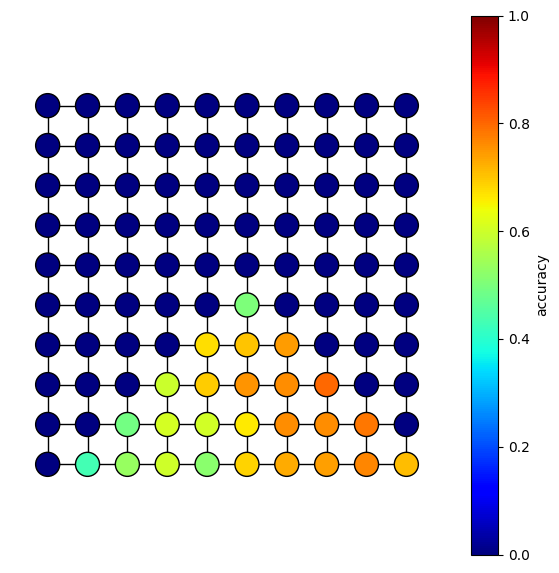

In [ ]:
network_type = 'square'
G = generate_graph('square')
nodes_list = list(G.nodes())

colors = np.zeros(G.number_of_nodes())
for i,co in enumerate(coor):
    n = (co[0],co[1])
    i_n = nodes_list.index(n)
    colors[i_n] = acc[i]


pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
fig, ax = plt.subplots(figsize=(7, 7))
nx.draw(G, with_labels=False, pos=pos,
        edgecolors='k',
        node_color=colors, cmap=plt.cm.jet, vmin=0, vmax=1, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=Normalize(vmin=0, vmax=1)), ax=ax, label='accuracy')
ax.axis('scaled')
plt.show()

# accruacy against noise of the inputs for different number of inputs for various types of networks

Text(0, 0.5, 'accuracy')

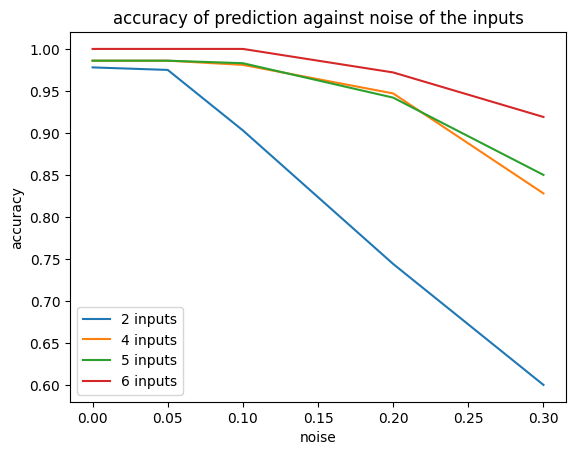

In [ ]:
#square
plt.figure()
noises = np.array([0.000, 0.050, 0.100, 0.200, 0.300])
l1 = np.array([0.978, 0.975, 0.903, 0.744, 0.600])
l2 = np.array([0.986, 0.986, 0.981, 0.947, 0.828])
l3 = np.array([0.986, 0.986, 0.983, 0.942, 0.850])
l4 = np.array([1.000, 1.000, 1.000, 0.972, 0.919])
plt.plot(noises, l1, label='2 inputs')
plt.plot(noises, l2, label='4 inputs')
plt.plot(noises, l3, label='5 inputs')
plt.plot(noises, l4, label='6 inputs')
plt.title('accuracy of prediction against noise of the inputs')
plt.legend()
plt.xlabel('noise')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

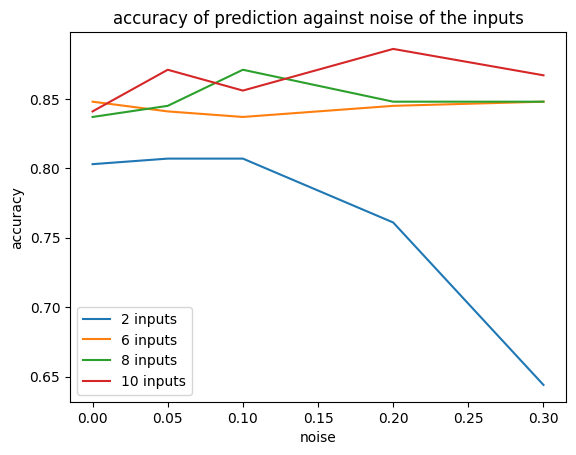

In [ ]:
#hex
plt.figure()
noises = np.array([0.000, 0.050, 0.100, 0.200, 0.300])
l1 = np.array([0.803, 0.807, 0.807, 0.761, 0.644])
l2 = np.array([0.848, 0.841, 0.837, 0.845, 0.848])
l3 = np.array([0.837, 0.845, 0.871, 0.848, 0.848])
l4 = np.array([0.841, 0.871, 0.856, 0.886, 0.867])
plt.plot(noises, l1, label='2 inputs')
plt.plot(noises, l2, label='6 inputs')
plt.plot(noises, l3, label='8 inputs')
plt.plot(noises, l4, label='10 inputs')
plt.title('accuracy of prediction against noise of the inputs')
plt.legend()
plt.xlabel('noise')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

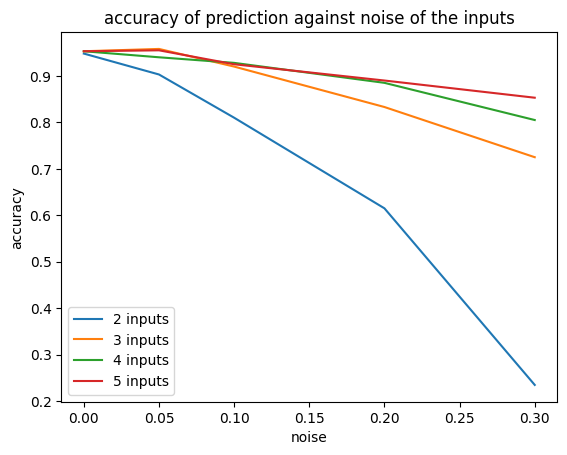

In [ ]:
#per_att
plt.figure()
noises = np.array([0.000, 0.050, 0.100, 0.200, 0.300])
l1 = np.array([0.948, 0.903, 0.810, 0.615, 0.235])
l2 = np.array([0.953, 0.958, 0.920, 0.833, 0.725])
l3 = np.array([0.953, 0.940, 0.928, 0.885, 0.805])
l4 = np.array([0.953, 0.955, 0.925, 0.890, 0.853])
plt.plot(noises, l1, label='2 inputs')
plt.plot(noises, l2, label='3 inputs')
plt.plot(noises, l3, label='4 inputs')
plt.plot(noises, l4, label='5 inputs')
plt.title('accuracy of prediction against noise of the inputs')
plt.legend()
plt.xlabel('noise')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

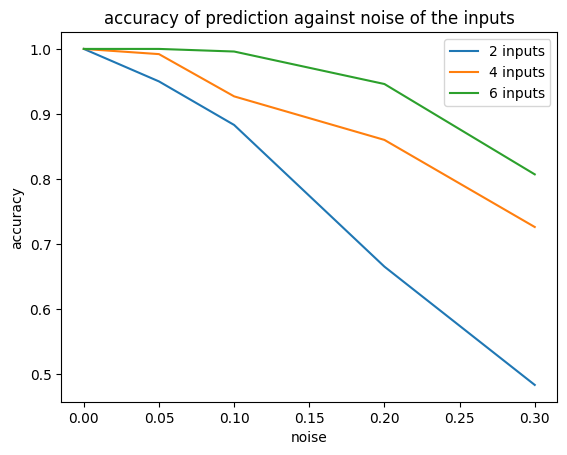

In [ ]:
#tri
plt.figure()
noises = np.array([0.000, 0.050, 0.100, 0.200, 0.300])
l1 = np.array([1.000, 0.950, 0.883, 0.665, 0.483])
l2 = np.array([1.000, 0.992, 0.927, 0.860, 0.726])
l3 = np.array([1.000, 1.000, 0.996, 0.946, 0.807])
plt.plot(noises, l1, label='2 inputs')
plt.plot(noises, l2, label='4 inputs')
plt.plot(noises, l3, label='6 inputs')
plt.title('accuracy of prediction against noise of the inputs')
plt.legend()
plt.xlabel('noise')
plt.ylabel('accuracy')

# Plot the variance, mean and index of dispersion of the voltage change at each node

<ipython-input-3-9724a6cf2513>:24: RuntimeWarning: invalid value encountered in divide
  iod = var/mean


[0.         0.10065454 0.07239188 0.06196705 0.0573611  0.05518622
 0.05420703 0.05377034 0.05361305 0.05347752 0.09784555 0.07351884
 0.06361443 0.05861521 0.05612353 0.05485907 0.05431864 0.05405021
 0.05377763 0.05351672 0.07500234 0.07013454 0.06360296 0.05918394
 0.05669781 0.05538601 0.05478817 0.05453245 0.05427906 0.05395306
 0.0628916  0.06135094 0.05873963 0.05679277 0.0555819  0.05505072
 0.05491863 0.05492235 0.05478582 0.05453024 0.05851255 0.05826645
 0.05747899 0.05637433 0.05557945 0.05521874 0.0553027  0.05567526
 0.0560232  0.05586304 0.05586304 0.0560232  0.05567526 0.0553027
 0.05521874 0.05557945 0.05637433 0.05747899 0.05826645 0.05851255
 0.05453024 0.05478582 0.05492235 0.05491863 0.05505072 0.0555819
 0.05679277 0.05873963 0.06135094 0.0628916  0.05395306 0.05427906
 0.05453245 0.05478817 0.05538601 0.05669781 0.05918394 0.06360296
 0.07013454 0.07500234 0.05351672 0.05377763 0.05405021 0.05431864
 0.05485907 0.05612353 0.05861521 0.06361443 0.07351884 0.097845

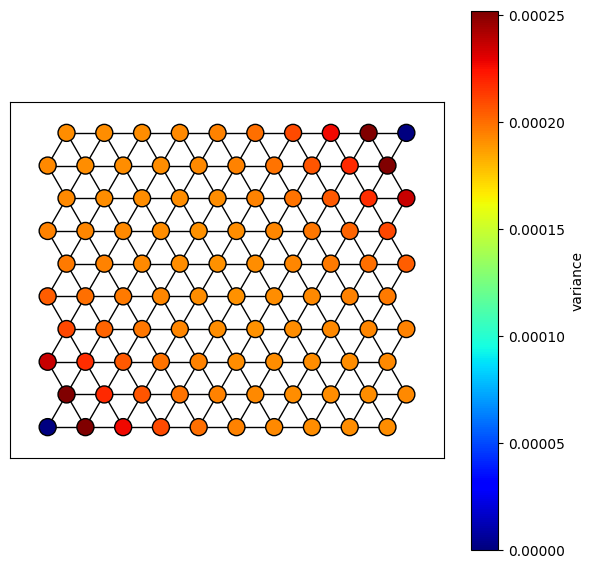

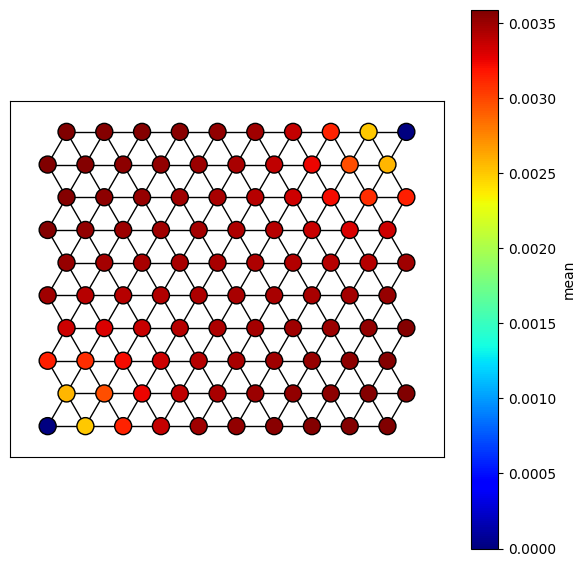

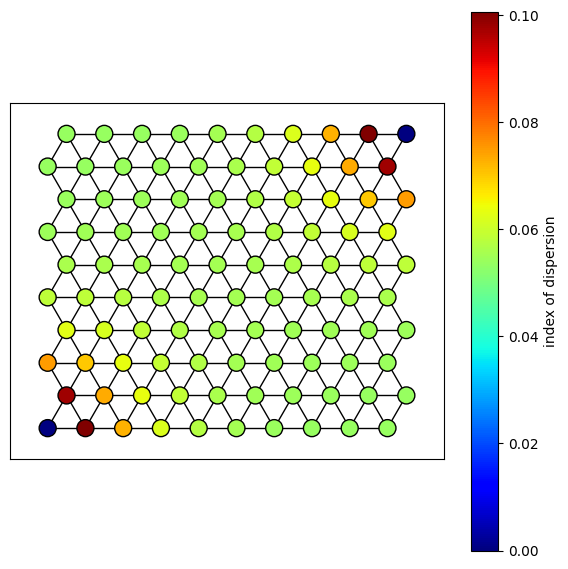

In [ ]:
network_type = 'tri'

G = generate_graph(network_type, L=10)
nodes_list = list(G.nodes())
if network_type == 'hex':
    high_V = nodes_list.index((0,8))
    low_V = nodes_list.index((7,8))
else:
    high_V = 0
    low_V = -1

V = get_V(G, high_V , low_V)
N = G.number_of_nodes()
edges = list(G.edges)
dVs = np.zeros((len(edges), N))
i = 0
for e in edges:
    dVs[i] = get_dV(G, V, e, high_V, low_V)
    i+=1

std = np.std(dVs, axis=0)
mean = np.mean(np.abs(dVs), axis=0)
var = std**2
iod = var/mean
iod[high_V] = 0
iod[low_V] = 0
print(iod)

pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
fig, ax = plt.subplots(figsize=(7, 7))
c_map = plt.cm.jet
nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=var, cmap=c_map, node_size=150, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(var), vmax=np.max(var))), ax=ax, label='variance')
ax.axis('scaled')
plt.show()

fig, ax = plt.subplots(figsize=(7, 7))
c_map = plt.cm.jet
nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=mean, cmap=c_map, node_size=150, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(mean), vmax=np.max(mean))), ax=ax, label='mean')
ax.axis('scaled')
plt.show()

fig, ax = plt.subplots(figsize=(7, 7))
c_map = plt.cm.jet
nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=iod, cmap=c_map, node_size=150, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(iod), vmax=np.max(iod))), ax=ax, label='index of dispersion')
ax.axis('scaled')
plt.show()

# Plot the first 4 principal components of the voltage changes at each node

Original shape: (261, 100)
Reduced shape: (261, 4)


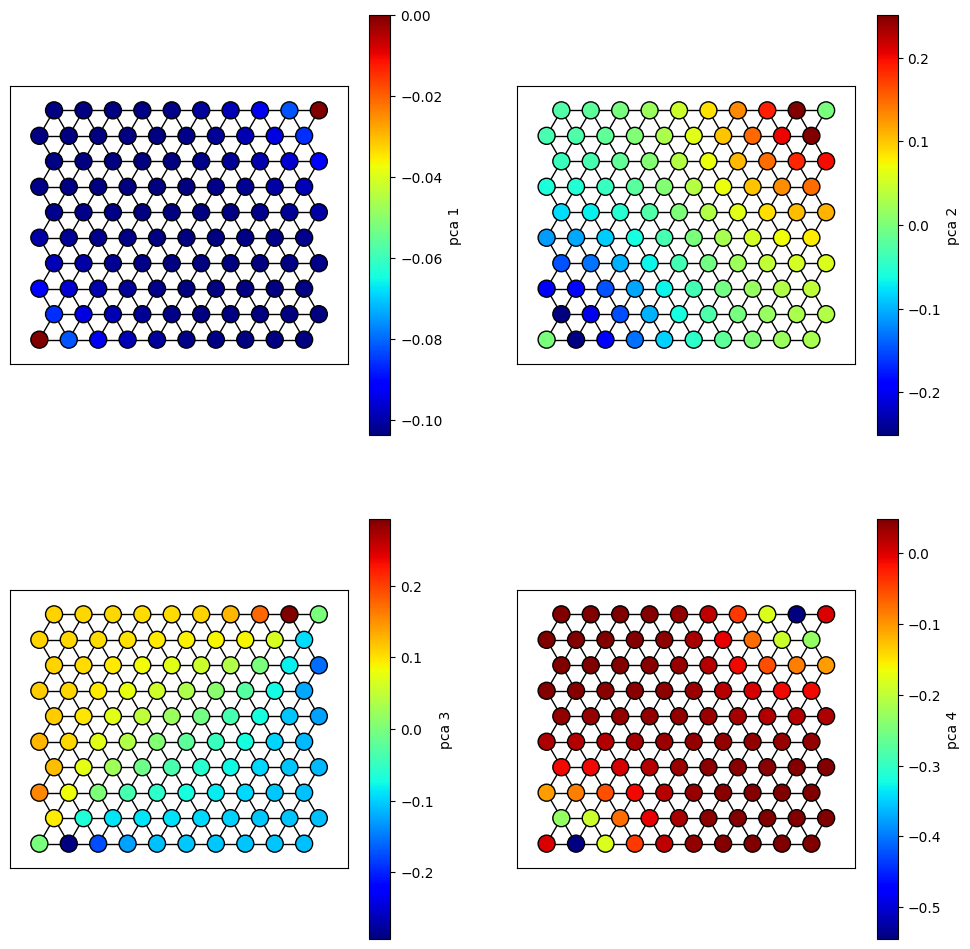

In [ ]:
num_inputs = 4

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(dVs)
X_scaled = scaler.transform(dVs)

from sklearn.decomposition import PCA
pca = PCA(n_components=num_inputs)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

plt.figure(figsize=(12,12))
for i in range(num_inputs):
    var = pca.components_[i]
    pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
    ax = plt.subplot(2, 2, i+1)
    c_map = plt.cm.jet
    nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=var, cmap=c_map, node_size=150, ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(var), vmax=np.max(var))), ax=ax, label=f'pca {i+1}')
    ax.axis('scaled')
plt.show()


# tried to use the pairwise correlation of voltage changes to find the most important node to measure

In [ ]:
df = pd.DataFrame(X_scaled)
cov = df.cov
plt.imshow(df, cmap ="RdYlBu")
plt.colorbar()

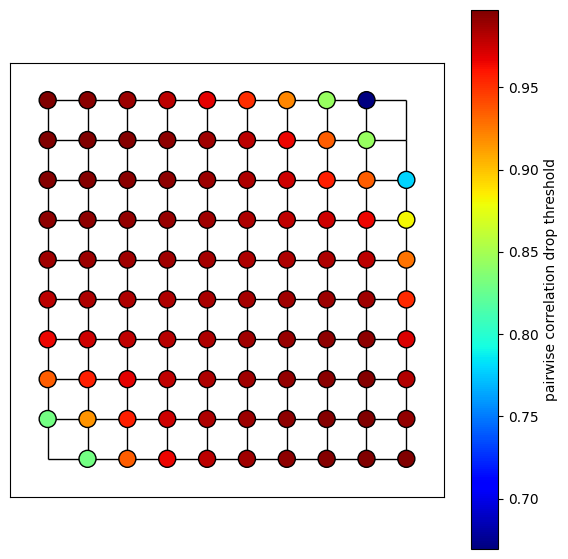

0          NaN
1     0.830259
2     0.935302
3     0.966026
4     0.979559
        ...   
95    0.926758
96    0.881699
97    0.779164
98         NaN
99         NaN
Length: 100, dtype: float64


In [ ]:
df = pd.DataFrame(X_scaled)
matrix = df.corr().abs()
mask = np.triu(np.ones_like(matrix, dtype=bool))
reduced_matrix = matrix.mask(mask)
drop_var = reduced_matrix.max()


pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
fig, ax = plt.subplots(figsize=(7, 7))
c_map = plt.cm.jet
nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=drop_var, cmap=c_map, node_size=150, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(drop_var), vmax=np.max(drop_var))), ax=ax, label='pairwise correlation drop threshold')
ax.axis('scaled')
plt.show()


print(drop_var)

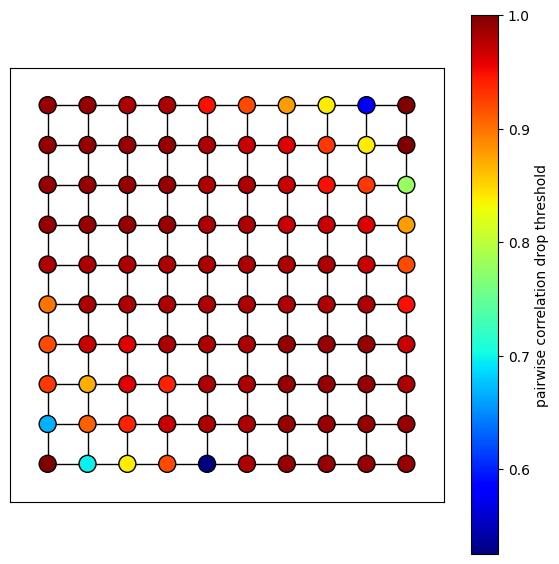

In [ ]:

df = pd.DataFrame(X_scaled)
drop_var = np.ones(len(df.columns))
#print(df)

def identify_correlated(df, threshold):
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    reduced_matrix = matrix.mask(mask)
    to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]

    return to_drop

for threshold in np.linspace(1,0,100):
    to_drop = identify_correlated(df, threshold)
    for i in to_drop:
        drop_var[i] = threshold
    df = df.drop(to_drop, axis=1)

pos = {(x, y): (x, y) for x, y in G.nodes()} if network_type == 'square' else G.nodes(data='pos')
fig, ax = plt.subplots(figsize=(7, 7))
c_map = plt.cm.jet
nx.draw_networkx(G, with_labels=False, pos=pos, edgecolors='k', node_color=drop_var, cmap=c_map, node_size=150, ax=ax)
fig.colorbar(plt.cm.ScalarMappable(cmap=c_map, norm=Normalize(vmin=np.min(drop_var), vmax=np.max(drop_var))), ax=ax, label='pairwise correlation drop threshold')
ax.axis('scaled')
plt.show()

# Plot the ring network construct in experiment

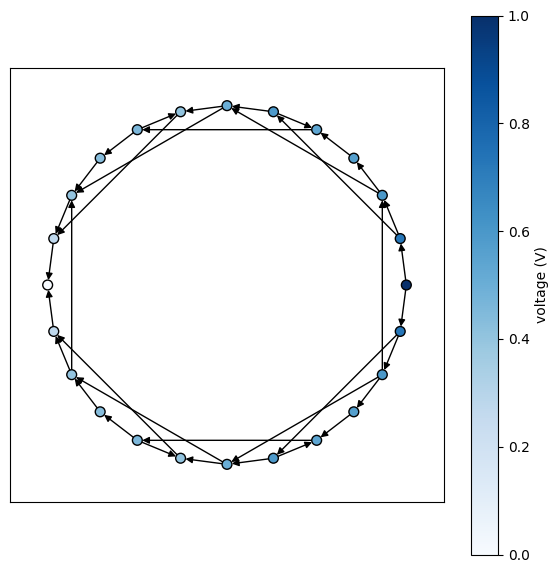

-0.026699650756693893
-0.013987194412107329
0.0015192083818389435
0.002497089639114769
[-0.026699650756693893, -0.013987194412107329, 0.0015192083818389435, 0.002497089639114769]
dim: 1.6549356327101115
N= 24


In [ ]:
network_type = 'ring'
N=24
m=4
p=1
G = generate_graph(network_type, N=N, ring_links=[1])
alt = True
for n in range(nx.number_of_nodes(G)):
    #if p>np.random.rand(): G.add_edge(n,int(np.random.rand()*nx.number_of_nodes(G)))
    if alt: G.add_edge(n,(n+m)%N)
    alt = not alt
high_V = 0
low_V = int(N/2)

G.add_edge(7,11)
G.add_edge(19,23)
G.add_edge(1,5)
G.add_edge(13,17)

G.remove_edge(0,4)
G.remove_edge(8,12)
G.remove_edge(12,16)
G.remove_edge(20,0)

V = get_V(G, high_V, low_V)
df = pd.DataFrame (V)
filepath = 'Vs_N24_p05.xlsx'
df.to_excel(filepath, index=False)


plot_graph(G, V, network_type)

dV = get_dV(G, V, (2,3), high_V, low_V)

m = 6
midpoints = np.empty(4, dtype = int)
midpoints = np.append(np.arange(1,m/2),np.arange(m/2+1,m))
midpoints = N/m*midpoints
inputs=[]
for n in midpoints:
    inputs.append(dV[int(n)])
    print(dV[int(n)])
print(inputs)

print(f'dim: {get_dim(G, cutoff=3)}')
print(f'N= {G.number_of_nodes()}')

# training for the above ring

In [ ]:
network_type = 'ring'
N=24
m=4
G = generate_graph(network_type, N=N)
alt = True
for n in range(nx.number_of_nodes(G)):
    if alt: G.add_edge(n,(n+m)%N)
    alt = not alt
high_V = 0
low_V = int(N/2)
G.add_edge(7,11)
G.add_edge(19,23)
G.add_edge(1,5)
G.add_edge(13,17)

G.remove_edge(0,4)
G.remove_edge(8,12)
G.remove_edge(12,16)
G.remove_edge(20,0)

generate_training_data(G, network_type, high_V, low_V, 'training_data.txt',
                    num_samples=-1, num_inputs=4, ran=0)


# Data loading
filename = 'training_data.txt'
data = pd.read_csv(filename, header=None)
X = data.values[:,:-1]
y = data.values[:,-1]

# Convert targets to one-hot encoding
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

num_classes = y.shape[1]  # Number of categories (edges)
pipeline = Pipeline(X_train, X_test, y_train, y_test, 0.0015, [4,128,128], num_classes)     #structure of DNN
accuracy, result, model, scaler = pipeline.run()

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('model_info.txt', 'w') as f:
    f.write(f'num_classes: {num_classes}\n')
    f.write(f'accuracy: {accuracy}\n')

[ 4.  8. 16. 20.]
0.25 complete


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation loss decreased (inf --> 3.468872).  Saving model ...
Validation loss decreased (3.468872 --> 2.985691).  Saving model ...
Validation loss decreased (2.985691 --> 2.783417).  Saving model ...
Validation loss decreased (2.783417 --> 2.659135).  Saving model ...
Validation loss decreased (2.659135 --> 2.555636).  Saving model ...
Validation loss decreased (2.555636 --> 2.447001).  Saving model ...
Validation loss decreased (2.447001 --> 2.320127).  Saving model ...
Validation loss decreased (2.320127 --> 2.204983).  Saving model ...
Validation loss decreased (2.204983 --> 2.098908).  Saving model ...
Validation loss decreased (2.098908 --> 2.004317).  Saving model ...
Validation loss decreased (2.004317 --> 1.923075).  Saving model ...
Validation loss decreased (1.923075 --> 1.845272).  Saving model ...
Validation loss decreased (1.845272 --> 1.761481).  Saving model ...
Validation loss decreased (1.761481 --> 1.676121).  Saving model ...
Validation loss decreased (1.676121 -->

# Predict location of edge removal using trained model

In [ ]:


# DNN model
class DNN(torch.nn.Module):
    def __init__(self, hidden, num_classes):
        super(DNN, self).__init__()
        self.out = torch.nn.Sequential(
            torch.nn.Linear(hidden[0], hidden[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden[1], hidden[2]),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden[2], num_classes)
        )
        for layer in self.out:
            if type(layer) == torch.nn.Linear:
                torch.nn.init.kaiming_normal_(layer.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.out(x)
        return out

def predict_removed_edge(G, edge_to_remove, high_V, low_V, model, scaler, network_type='per_att', num_samples=-1, num_inputs=4):
    N = nx.number_of_nodes(G)
    L = int(np.sqrt(N))  # Assuming square grid
    #midpoints = [(0, L//2), (L//2, 0), (L-1, L//2), (L//2, L-1), (L//2, L//2)]
    midpoints = [(0, L//2), (L//2, 0)]
    hubs = sorted(G.degree, key=lambda x: x[1], reverse=True)
    print(hubs)
    edges = list(G.edges)

    # Copy the graph and remove the specified edge
    G_copy = G.copy()
    G_copy.remove_edge(*edge_to_remove)

    # Calculate voltage changes
    V_original = get_V(G, high_V, low_V)
    V_new = get_V(G_copy, high_V, low_V)
    dV = V_new - V_original

    # Prepare inputs: dV for each midpoint
    inputs = []
    if network_type == 'square':
        for x, y in midpoints:
            node_index = x * L + y # Assuming nodes are numbered row-wise from 0 to N-1
            inputs.append(dV[node_index])
    elif network_type == 'per_att':
        for i in range(num_inputs):
            inputs.append(hubs[i])
    # Standardize the inputs in the same way as the training data
    inputs = scaler.transform(np.array(inputs).reshape(1, -1))

    # Convert inputs to a torch tensor
    inputs = torch.from_numpy(inputs).float()

    # If using a GPU, move the inputs to GPU memory
    if torch.cuda.is_available():
        inputs = inputs.cuda()

    # Make the prediction
    with torch.no_grad():
        model.eval()
        output = model(inputs)
        predicted_edge_index = torch.argmax(output).item()

    # Return the predicted edge to remove
    return edges[predicted_edge_index]

def predict_removed_edge_exp(inputs, model, scaler):
    # Standardize the inputs in the same way as the training data
    inputs = scaler.transform(np.array(inputs).reshape(1, -1))

    # Convert inputs to a torch tensor
    inputs = torch.from_numpy(inputs).float()

    # If using a GPU, move the inputs to GPU memory
    if torch.cuda.is_available():
        inputs = inputs.cuda()

    # Make the prediction
    with torch.no_grad():
        model.eval()
        output = model(inputs)
        predicted_edge_index = torch.argmax(output).item()

    edges = list(G.edges)
    # Return the predicted edge to remove
    return edges[predicted_edge_index]

with open('model_info.txt', 'r') as f:
    lines = f.readlines()
    num_classes = int(lines[0].split(': ')[1])
    accuracy = float(lines[1].split(': ')[1])

# Load model
model = DNN([4,128,128], num_classes)  # num_classes should be the number of edges in your graph
model.load_state_dict(torch.load('checkpoint.pt'))  # Assuming the model was saved in this file
if torch.cuda.is_available():
    model = model.cuda()

# Load scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)




In [ ]:
inputs =[-0.2639,-0.0381,-0.1151,-0.1219]
print(predict_removed_edge_exp(inputs, model, scaler))

(0, 1)


In [ ]:
# Create graph
G = generate_graph('per_att', N=100)

# Predict edge to remove
#edge_to_remove = ((2, 3), (2, 4))  # Replace with the edge you want to remove
edge_to_remove = (2,3)
high_V = 0
low_V = -2
predicted_edge = predict_removed_edge(G, edge_to_remove, high_V, low_V, model, scaler)
print(predicted_edge)